In [218]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import scipy.cluster.vq as km
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)

import tensorflow.examples.tutorials.mnist.input_data as import_data

import sys

class Model():
    def load_data(self):
        raise NotImplemented
    def add_placeholder(self):
        raise NotImplemented
    def create_feed_dict(self,input_batch, groundtruth_batch):
        raise NotImplemented
    def add_model(self, input_data):
        raise NotImplemented
    def add_loss_op(self, prediction):
        raise NotImplemented
    def add_training_op(self):
        raise NotImplemented
    def run_epoch(self, input_data, groundtruth_data):
        raise NotImplemented
    def fit(self, input_data, input_groundtruth):
        raise NotImplemented
    def __init__(self):
        raise NotImplemented
        

In [219]:
def softmax(x):
    """Softmax appliqué à chaque ligne de la matrice x"""
    #Trick numérique
    maxi = tf.expand_dims(tf.reduce_max(x, reduction_indices=1),1)
    exps = tf.exp(x-maxi)
    out = exps/(tf.expand_dims(tf.reduce_sum(exps, 1),1))
    
    return out

class SoftmaxClassifier(Model):
    def loadData(self):
        """Load data"""
        input_data = import_data.read_data_sets(self.config.filename, one_hot=True)
        self.input_data = input_data
        
        nb = input_data.train.num_examples
        self.config.n_samples = nb
        
        #Output
        self.config.n_classes = 10
            
        
    def add_placeholder(self):
        """Create placeholder"""
        with tf.variable_scope("placeholder"):
            #self.input_placeholder = tf.placeholder(tf.float32, (self.config.batchsize, self.config.n_features))
            #self.label_placeholder = tf.placeholder(tf.int32, (self.config.batchsize,self.config.n_classes))
            #None pour pouvoir prédire des exemples seuls
            self.input_placeholder = tf.placeholder(tf.float32, (None, self.config.n_features),name="input_ph")
            self.label_placeholder = tf.placeholder(tf.int32, (None,self.config.n_classes))
    
    def create_feed_dict(self, input_batch, label_batch=None):
        if label_batch is None:
            feed_dict = {self.input_placeholder:input_batch}
        else:
            feed_dict = {self.input_placeholder:input_batch, self.label_placeholder:label_batch}
        return feed_dict
    
    def add_model(self,input_data):
        #Réseau à une seule couche
        # h = softmax(xW + b)
        x = input_data
        with tf.variable_scope("hidden"):
            W1 = tf.get_variable("weights", 
                                shape=(self.config.n_features, self.config.hiddensize), 
                                initializer=tf.contrib.layers.xavier_initializer())
            
            b1 = tf.get_variable("bias",
                               shape = (1,self.config.hiddensize),
                               initializer=tf.contrib.layers.xavier_initializer())
            
            z1 = tf.matmul(x,W1) + b1
            x1 = tf.nn.tanh(z1)
            
        with tf.variable_scope('softmax'):
            W2 = tf.get_variable("weights", 
                                shape=(self.config.hiddensize, self.config.n_classes), 
                                initializer=tf.contrib.layers.xavier_initializer())
            
            b2 = tf.get_variable("bias",
                               shape = (1,self.config.n_classes),
                               initializer=tf.contrib.layers.xavier_initializer())
            
            z2 = tf.matmul(x1,W2) + b2
            h = softmax(z2)
        
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2
        self.model = h
    
    def add_loss_op(self, predictions):
        if self.config.l2_loss:
            loss = - tf.reduce_sum(tf.to_float(self.label_placeholder) * tf.log(predictions)) \
                    + self.config.l2_loss * tf.nn.l2_loss(self.W1) \
                    + self.config.l2_loss * tf.nn.l2_loss(self.W2)
        else:
            loss = - tf.reduce_sum(tf.to_float(self.label_placeholder) * tf.log(predictions))
        self.loss = loss
    
    def add_training_op(self):
        train_op = tf.train.GradientDescentOptimizer(self.config.lr).minimize(self.loss)
        self.train_op = train_op
    
    def run_epoch(self,sess):
        #Création des batches : on partitionne le dataset en sous batches
        nb_batch = int(np.floor(float(self.config.n_samples) / self.config.batchsize ))
        batches = []
        for i in range(nb_batch):
            batches.append( self.input_data.train.next_batch(self.config.batchsize) )
        
        #Itération sur les différents batches
        average_loss = 0
        for i, (input_batch, label_batch) in enumerate(batches):
            #On crée le feed_dict
            feed_dict = self.create_feed_dict(input_batch, label_batch)
            _, loss = sess.run([self.train_op, self.loss], feed_dict=feed_dict)
            average_loss += loss
        
        
        return average_loss/i
            
    def fit(self,sess=None):
        if sess is None:
            sess = self.session
        losses = []
        for i in range(self.config.nb_epoch):
            losses.append(self.run_epoch(sess))
            if i%self.config.printrate == 0:
                print '\r%d %f' %(i,np.mean(losses)),
            
            """if i % (self.config.nb_epoch//4) == 0:
                map2d(self,num = 200)"""
    
    def predict(self, input_data, sess=None):
        if sess is None:
            sess = self.session
        res = tf.arg_max(self.model,1)
        feed_dict = self.create_feed_dict(input_data)    
        return sess.run(res,feed_dict=feed_dict)
        
       
    def add_placeholder_reverse(self):
        with tf.variable_scope("placeholder"):
            self.W1_placeholder = tf.placeholder(tf.float32, (self.config.n_features, self.config.hiddensize))
            self.b1_placeholder = tf.placeholder(tf.float32, (1,self.config.hiddensize))
            self.W2_placeholder = tf.placeholder(tf.float32, (self.config.hiddensize, self.config.n_classes))
            self.b2_placeholder = tf.placeholder(tf.float32, (1,self.config.n_classes))
    
    def create_feed_dict_reverse(self, label):
        d = dict([
                (self.W1_placeholder,self.session.run(self.W1)),
                (self.W2_placeholder,self.session.run(self.W2)),
                (self.b1_placeholder,self.session.run(self.b1)),
                (self.b2_placeholder,self.session.run(self.b2)),
                (self.label_placeholder, label)
            ])
        self.feed_dict_reverse = d
    
    def add_model_reverse(self):
        with tf.variable_scope("input"):
            x = tf.get_variable("x", dtype=tf.float32, shape=(1,self.config.n_features))
        with tf.variable_scope("hiddenReverse"):
            z1 = tf.matmul(x,self.W1_placeholder) + self.b1_placeholder
            x1 = tf.nn.tanh(z1)
            
        with tf.variable_scope('softmaxReverse'):
            z2 = tf.matmul(x1,self.W2_placeholder) + self.b2_placeholder
            h = softmax(z2)
        
        self.x = x
        self.model_reverse = h
        
    def add_loss_op_reverse(self, predictions):
        if self.config.l2_loss:
            loss = - tf.reduce_sum(tf.to_float(self.label_placeholder) * tf.log(predictions)) \
                    + self.config.l2_loss * tf.nn.l2_loss(self.x)
        else:
            loss = - tf.reduce_sum(tf.to_float(self.label_placeholder) * tf.log(predictions))
        self.loss_reverse = loss
    
    def add_training_op_reverse(self):
        train_op = tf.train.GradientDescentOptimizer(self.config.lr).minimize(self.loss_reverse)
        self.train_op_reverse = train_op
    
    def run_epoch_reverse(self):
        _,loss = self.session.run([self.train_op_reverse, self.loss_reverse], feed_dict=self.feed_dict_reverse)
        return loss
    
    def fit_reverse(self,label):
        label_hot = np.zeros((1,10), dtype='int')
        label_hot[0,label] = 1
        self.create_feed_dict_reverse(label_hot)
        losses = []
        for i in range(self.config.nb_epoch):
            losses.append(self.run_epoch_reverse())
            if i%self.config.printrate == 0:
                print '\r%d %f' %(i,losses[-1]),
        
        return losses[-1]
    
    def __init__(self):
        self.config = Config()
        self.loadData()
        self.add_placeholder()
        self.add_model(self.input_placeholder)
        self.add_loss_op(self.model)
        self.add_training_op()
        
        self.add_placeholder_reverse()
        self.add_model_reverse()
        self.add_loss_op_reverse(self.model_reverse)
        self.add_training_op_reverse()
        
        
        
        self.session = tf.Session()
        self.session.run(tf.initialize_all_variables())





class Config():
    batchsize = 30
    lr = 0.01
    filename = "dataset/MNIST"
    n_features = 784
    nb_epoch = 100
    l2_loss = 0.01
    hiddensize = 1000
    printrate = 1
    
    n_classes = 0
    n_samples = 0
    

In [220]:
tf.reset_default_graph()
tset = SoftmaxClassifier()

Extracting dataset/MNIST/train-images-idx3-ubyte.gz
Extracting dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting dataset/MNIST/t10k-labels-idx1-ubyte.gz


In [214]:
tf.reset_default_graph()
tset = SoftmaxClassifier()
tset.fit()

Extracting dataset/MNIST/train-images-idx3-ubyte.gz
Extracting dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting dataset/MNIST/t10k-labels-idx1-ubyte.gz
99 3.637055


In [215]:
tset.fit()

99 3.616000


In [208]:
with tf.variable_scope("stet"):
    stet = SoftmaxClassifier()
    stet.fit()

Extracting dataset/MNIST/train-images-idx3-ubyte.gz
Extracting dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting dataset/MNIST/t10k-labels-idx1-ubyte.gz
999 3.194213


In [216]:
tset.config.nb_epoch = 1000
for i in range(10):
    tset.session.run(tf.initialize_variables([tset.x]))
    old = tset.fit_reverse(i)
    new = tset.fit_reverse(i)
    c = 0
    while abs(new-old) > 0.0000001:
        c+=1
        old,new = new, tset.fit_reverse(i)
    plt.imsave("%d_reverse"%i, tset.session.run(tset.x).reshape((28,28)))
    print("\r%d : %d iterations"%(i,c))

0 : 75 iterations
1 : 78 iterations
2 : 78 iterations
3 : 78 iterations
4 : 78 iterations
5 : 76 iterations
6 : 75 iterations
7 : 77 iterations
8 : 78 iterations
9 : 77 iterations


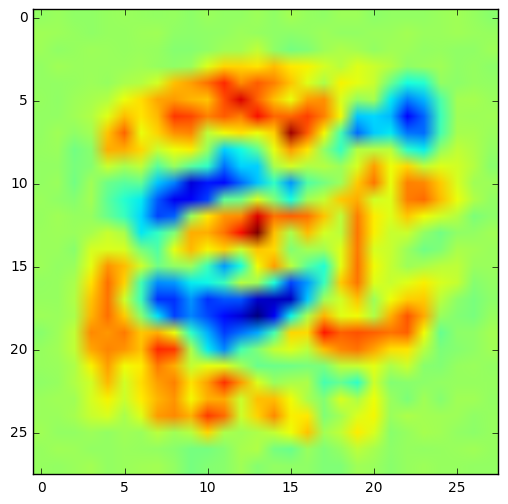

In [194]:
plt.imshow(tset.session.run(tset.x).reshape((28,28)))

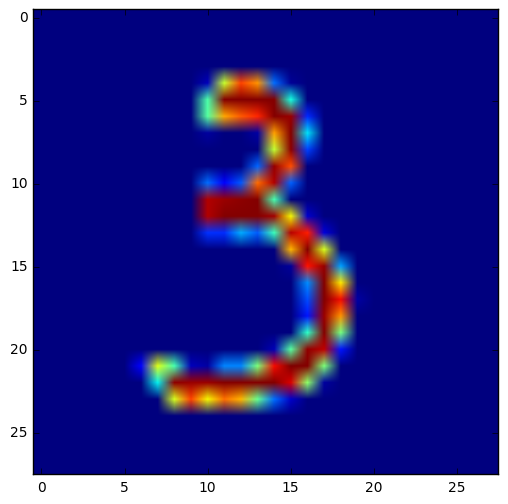

In [70]:
for i in range(100):
    j = tset.predict([a.test.images[i]])[0]
    plt.imshow(a.test.images[i].reshape((28,28)))
    plt.imsave("%d_%d"%(i,j ), a.test.images[i].reshape((28,28)))

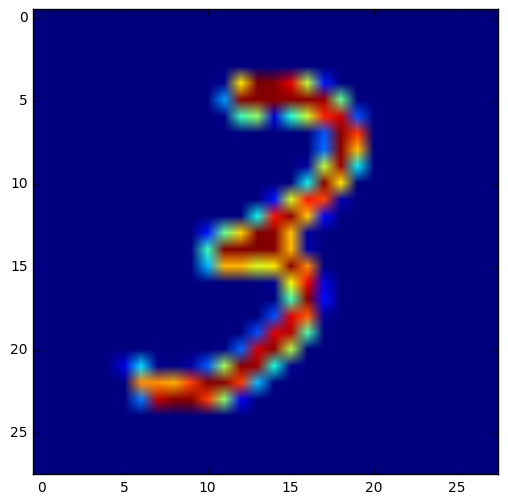

In [217]:
error = SoftmaxClassifier()

Extracting dataset/MNIST/train-images-idx3-ubyte.gz
Extracting dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting dataset/MNIST/t10k-labels-idx1-ubyte.gz


ValueError: Variable hidden/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-213-59d9e55f2d62>", line 46, in add_model
    initializer=tf.contrib.layers.xavier_initializer())
  File "<ipython-input-213-59d9e55f2d62>", line 185, in __init__
    self.add_model(self.input_placeholder)
  File "<ipython-input-214-b92d5d5b39b6>", line 2, in <module>
    tset = SoftmaxClassifier()
